# Comparing beamconv and ducc
In this script, we check the agreement of the TOD returned by ducc and beamconv. The first half of this script is based on [comparison_script.py](https://github.com/AdriJD/beamconv/blob/muellerconvolver_comparison/comparison_script.py) from the muellerconvolver_comparison branch in beamconv.

First, we import a few useful libraries.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import mueller_convolver
import ducc0

from beamconv import Beam, ScanStrategy, tools
import qpoint as qp

import scanning_mod

# setting up some plotting-related stuff
plt.rcParams.update({
    "font.size":10.95,
    "text.usetex":True,
    "font.family":"serif", 
    "font.serif":"cm"
    })

And define a few useful functions.

In [6]:
def nalm(lmax, mmax):
    return ((mmax+1)*(mmax+2))//2 + (mmax+1)*(lmax-mmax)

def make_full_random_alm(lmax, mmax, rng):
    res = rng.uniform(-1., 1., (4, nalm(lmax, mmax))) \
     + 1j*rng.uniform(-1., 1., (4, nalm(lmax, mmax)))
    # make a_lm with m==0 real-valued
    res[:, 0:lmax+1].imag = 0.
    ofs=0
    # components 1 and 2 are spin-2, fix them accordingly
    spin=2
    for s in range(spin):
        res[1:3, ofs:ofs+spin-s] = 0.
        ofs += lmax+1-s
    return res

def get_gauss_beam_from_beamconv(fwhm, lmax):
    import beamconv
    blmT, blmm2 = beamconv.tools.gauss_blm(fwhm*180*60/np.pi, lmax, pol=True)
    res = np.zeros((4,blmT.shape[0]), dtype=np.complex128)
    blmE, blmB = beamconv.tools.spin2eb(blmm2, blmm2*0, spin=2)
    res[0] = blmT
    res[1] = blmE
    res[2] = blmB
    res[3] = blmT  # correct?
    return res

def blm_gauss_new(fwhm, lmax, pol=False):
    fwhm = float(fwhm)
    lmax = int(lmax)
    pol = bool(pol)
    mmax = 2 if pol else 0
    ncomp = 3 if pol else 1
    nval = hp.Alm.getsize(lmax, mmax)

    if mmax > lmax:
        raise ValueError("lmax value too small")

    blm = np.zeros((ncomp, nval), dtype=np.complex128)
    sigmasq = fwhm * fwhm / (8 * np.log(2.0))

    for l in range(lmax+1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] = np.exp(-0.5*sigmasq*l*(l+1))

    if pol:
        for l in range(2, lmax+1):
            blm[1, hp.Alm.getidx(lmax, l, 2)] = np.exp(-0.5 * sigmasq * (l*(l+1)-4))
        blm[2] = 1j * blm[1]

    return blm

# blm_gauss_new times sqrt((2*l+1)/(4pi))
def Blm_gauss_new(fwhm, lmax, pol=False):
    blm = blm_gauss_new(fwhm, lmax, pol)
    for l in range(lmax+1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] *= np.sqrt((2*l+1) / (4*np.pi))

    if pol:
        for l in range(2, lmax+1):
            blm[1:3, hp.Alm.getidx(lmax, l, 2)] *= np.sqrt((2*l+1) / (4*np.pi))

    return blm

# code by Marta to get beamconv results for user-specified angles
def get_beamconv_values(lmax, kmax, slm, blm, ptg, hwp_angles, mueller,
                        mu_con_hwp, mu_con_spin):
    import beamconv
    import qpoint as qp

    # prepare PO beam file
    blm2 = np.zeros((blm.shape[0], hp.Alm.getsize(lmax=lmax)), dtype=np.complex128)
    blm2[:,:blm.shape[1]] = blm
    blmm, blmp = beamconv.tools.eb2spin(blm2[1],blm2[2])
    blm2[1] = blmm
    blm2[2] = blmp
    np.save("temp_beam.npy", blm2)

    # set up beam and HWP mueller matrix (identity, i.e. no HWP)
    beam = beamconv.Beam(btype='PO', lmax=lmax, mmax=lmax, deconv_q=True, normalize=False, po_file="temp_beam.npy", hwp_mueller=mueller)

    nsamp = ptg.shape[0]

    # from (theta,phi) to (ra,dec) convention
    # also, all angles are converted to degrees
    ra = np.degrees(ptg[:,1])
    dec = 90. - np.degrees(ptg[:,0])
    # Adjustment for difference in convention between qpoint and MuellerConvolver?
    psi = 180. - np.degrees(ptg[:,2])

    # calculate the quaternion
    q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

    def ctime_test(**kwargs):
        return np.zeros(kwargs.pop('end')-kwargs.pop('start'))
    
    def q_bore_test(**kwargs):
        return q_bore_array[kwargs.pop('start'):kwargs.pop('end')]

    S = beamconv.ScanStrategy(duration=nsamp, sample_rate=1, external_pointing=True, use_l2_scan=False)
    S.add_to_focal_plane(beam, combine=False)
    S.set_hwp_mod(mode='stepped', freq=1, angles=hwp_angles*180/np.pi)

    # determine nside_spin necessary for good accuracy
    nside_spin = 1
    while nside_spin < 4*lmax:
        nside_spin *= 2

    S.scan_instrument_mpi(slm.copy(), save_tod=True, ctime_func=ctime_test, q_bore_func=q_bore_test,
                      ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin, interp=True, input_v=True, beam_v=True, max_spin=kmax+4, binning=False, verbose=0, mu_con_hwp=mu_con_hwp, mu_con_spin=mu_con_spin)

    return S.data(S.chunks[0], beam=beam, data_type='tod').copy()

We set up some variables.

In [ ]:
np.random.seed(10)
rng = np.random.default_rng(np.random.SeedSequence(42))
nside = 64
lmax = 2*nside
mmax = 2
kmax = 18
npix = 12*nside**2

And define completely random beam and sky spherical harmonics coefficients, together with a completely random Mueller matrix and pointings.

In [ ]:
# completely random beam
blm = make_full_random_alm(lmax, kmax, rng)

In [ ]:
# completely random sky
slm = make_full_random_alm(lmax, lmax, rng)

In [ ]:
# completely random Mueller matrix
mueller = np.random.uniform(-1,1,size=(4,4))

In [ ]:
# completely random pointings
nptg=100
ptg = np.empty((nptg,3))
ptg[:,0]=np.random.uniform(0,np.pi,size=(nptg,))       # theta
ptg[:,1]=np.random.uniform(0,2*np.pi,size=(nptg,))     # phi
ptg[:,2]=np.random.uniform(0,2*np.pi,size=(nptg,))     # psi
hwp_angles = np.random.uniform(0,2*np.pi,size=(nptg,)) # alpha

Finally, we simulate the TOD associated to the specifics we just introduced.

In [ ]:
# get the signal from beamconv
signal_beamconv_TT = get_beamconv_values(lmax=lmax, kmax=kmax, slm=slm, blm=blm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller, mu_con_hwp=True, mu_con_spin=True)

In [ ]:
# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=slm,
    blm=blm,
    mueller=mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=hwp_angles)

del(fullconv)

To compare the two TOD, we print the L2 error and plot them, together with their difference.

In [ ]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv_TT, signal_muellerconvolver))

In [ ]:
# plotting diff
plt.plot(signal_muellerconvolver, color='gold', label="muellerconvolver")
plt.plot(signal_beamconv_TT, color='red', linestyle=':', label="beamconv")
plt.plot(signal_muellerconvolver-signal_beamconv_TT, color='black', label="difference")
plt.legend(loc='lower right')
plt.show()

The small discrepancies between the two TOD arise from the fact that we are running ducc with nside=64, while beamconv internally assumes nside=256. If we increase nside, the discrepancies get lower.

<a style="color:Red;">TODO: explain whatever is happening from here on</a>

In [13]:
# lines from cells above, #FIXME: to be removed
np.random.seed(10)
rng = np.random.default_rng(np.random.SeedSequence(42))
nside = 64
lmax = 2*nside
mmax = 2
kmax = 18
npix = 12*nside**2
# completely random sky
slm = make_full_random_alm(lmax, lmax, rng)

In [2]:
ctim0 = 1510000000                    # initial time

duration = 3600*24                    # mission duration in s (1 days)

fsamp = 19.1                          # sampling frequency in Hz
nsamp = int(duration*fsamp)           # number of samples

t_samp_array = np.arange(nsamp)/fsamp # array of the sampled times

def ctime_test(**kwargs):
    return np.zeros(kwargs.pop('end')-kwargs.pop('start'))

In [3]:
ptg = np.empty((nsamp,3))             # initializing pointings array
ptg[:,0]=np.pi*np.arange(nsamp)/nsamp # theta
ptg[:,1]=np.radians(55.66)            # phi
ptg[:,2]=np.arange(nsamp)*1e-4        # psi

# from (theta,phi) to (ra,dec) convention
# also, all angles are converted in degrees
ra = np.degrees(ptg[:,1])
dec = 90. - np.degrees(ptg[:,0])
# Adjustment for difference in convention between qpoint and MuellerConvolver?
psi = 180. - np.degrees(ptg[:,2])

# calculate the boresight quaternions
q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

def q_bore_test(**kwargs):
    return q_bore_array[kwargs.pop('start'):kwargs.pop('end')]

In [4]:
ndet = 1

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))
off_quats = np.zeros((ndet,2,4))
deads = np.array([[0,1]])

off_ra, off_dec, off_pa = 10., 87., 10.
off_quats[0,0,:] = qp.QPoint().radecpa2quat(off_ra, off_dec, off_pa)

In [86]:
fwhm_arcmin = 5.
fwhm_rad = np.radians(fwhm_arcmin/60.)

# completely random beam
blm_new = make_full_random_alm(lmax, kmax, rng)

# ... or use a Gauss beam
blmtmp = blm_gauss_new(fwhm_rad,lmax,pol=True)
blm_new *= 0
blm_new[0:3, 0:blmtmp.shape[1]] = blmtmp

#blm_new[:, 1:] *= 0. #FIXME: this works!
#blm_new[:, 2:] *= 0. #FIXME: this doesn't work already, ducc's TOD is monotonic, while beamconv's oscillates
#blm_new[1:, :] *= 0. #FIXME: this doesn't work already.

# prepare PO beam file
blm2 = np.zeros((blm_new.shape[0], hp.Alm.getsize(lmax=lmax)), dtype=np.complex128)
blm2[:,:blm_new.shape[1]] = blm_new
blmm, blmp = tools.eb2spin(blm2[1],blm2[2])
blm2[1] = blmm
blm2[2] = blmp
np.save("temp_beam.npy", blm2)

from line 4556 of instrument.py: [-2.77555756e-17  2.57792616e-02  4.54557937e-03  9.99657325e-01]


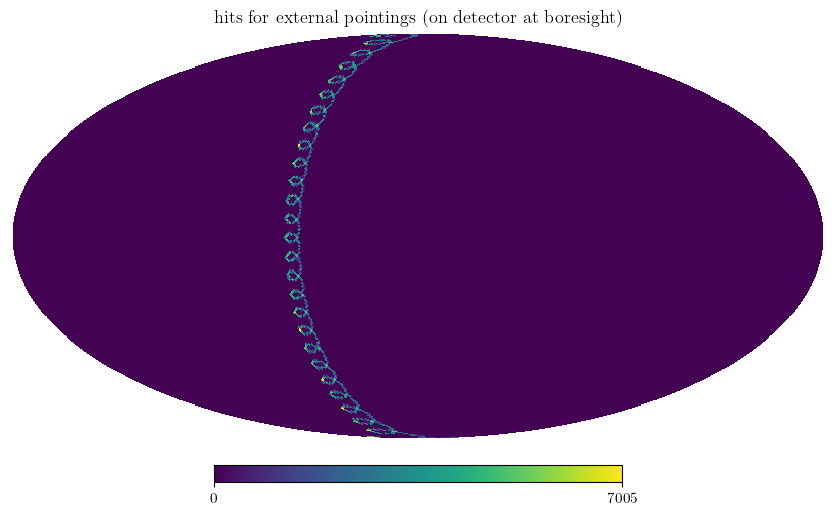

In [87]:
mu_con_spin = True
mu_con_hwp = True

# provide HWP stuff
mueller = np.diag([1,1,1,1])
hwp_angles = np.zeros(nsamp)

# setting up the beam options
beam_opts_quats = dict(btype='PO',
                       lmax=lmax,
                       mmax=lmax,
                       deconv_q=True,
                       normalize=False,
                       po_file="temp_beam.npy",
                       hwp_mueller=mueller,
                       quats=off_quats)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True, use_l2_scan=False)
S_ptg.input_focal_plane(azs, els, polangs, deads=deads, combine=True, scatter=False, **beam_opts_quats)
S_ptg.allocate_maps(nside=nside)

S_ptg.scan_instrument_mpi(slm, save_tod=True, save_point=True, ctime_func=ctime_test, q_bore_func=q_bore_test, 
                          interp=True, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=mu_con_hwp, mu_con_spin=mu_con_spin,
                          ctime_kwargs=dict(), q_bore_kwargs=dict())

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

hp.mollview(proj[0], title=r'')
plt.title('hits for external pointings (on detector at boresight)')

signal_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='tod').copy()
pixels_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pix').copy()
pa_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pa').copy()

del(S_ptg, cond)

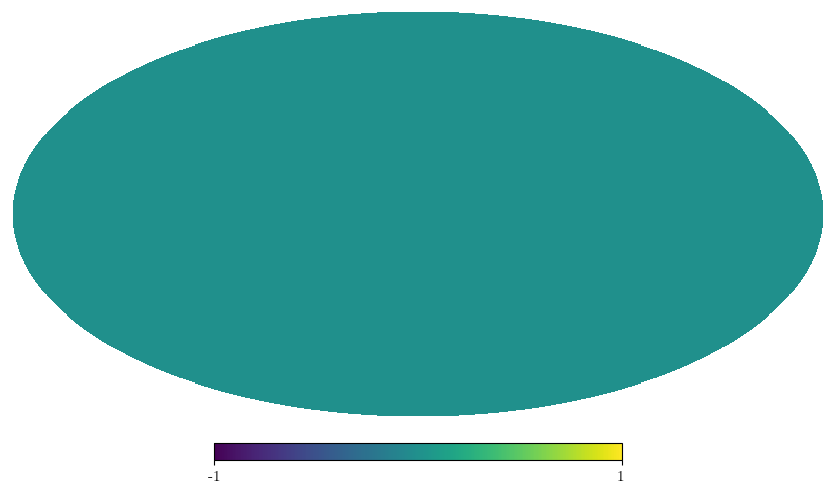

0.0


In [88]:
ptg4ducc = np.copy(ptg)
#ptg4ducc[:,2] = np.pi - ptg4ducc[:,2]

q_bore_ducc = ducc0.misc.ptg2quat(ptg4ducc)

off_quat = np.roll(off_quats[0,0],-1)
off_quat[0] *= -1

new_quats = np.empty((nsamp,4))

pp = ducc0.pointingprovider.PointingProvider(t0=ctim0, freq=fsamp, quat=q_bore_ducc, nthreads=1)
rotated_quats = pp.get_rotated_quaternions(t0=ctim0, freq=fsamp, rot=off_quat, rot_left=True, out=new_quats)

rotated_pointings = np.empty((nsamp, 3))

for k in np.arange(nsamp):
    rotated_pointings[k] = ducc0.misc.quat2ptg(rotated_quats[k])
    
rotated_pointings[:,2] = scanning_mod.wraparound_npi(rotated_pointings[:,2],2)

pixs = hp.ang2pix(nside, rotated_pointings[:,0], rotated_pointings[:,1])
hits1 = np.bincount(pixs,minlength=npix)

hp.mollview(proj[0]-hits1, title='')
plt.show()
print(np.max(proj[0]-hits1))

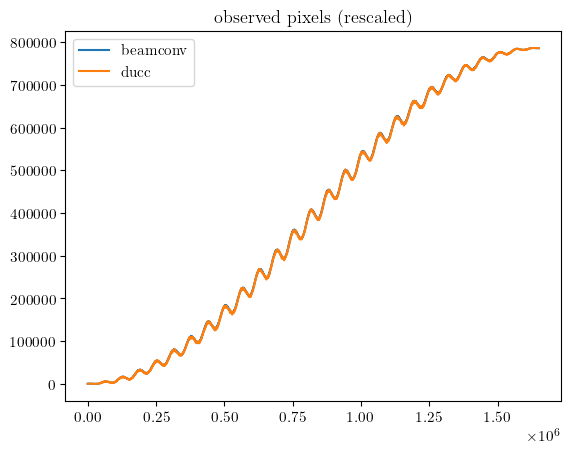

In [89]:
plt.plot(pixels_beamconv, label='beamconv')
plt.plot(pixs*(256/nside)**2, label='ducc')
plt.title(r'observed pixels (rescaled)')
plt.legend()
plt.show()

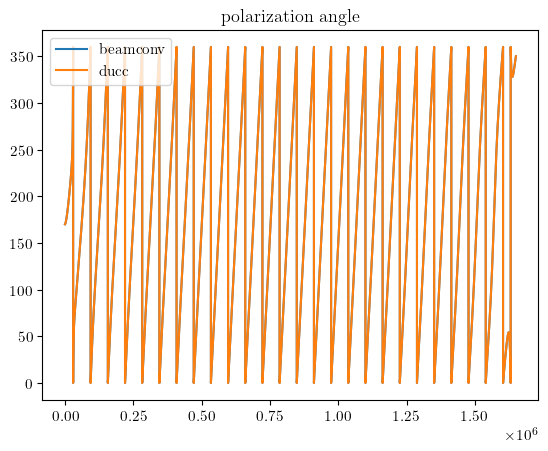

In [90]:
plt.plot(pa_beamconv, label='beamconv')
plt.plot(np.degrees(rotated_pointings[:,2]), label='ducc')
plt.title(r'polarization angle')
plt.legend()
plt.show()

Finally, we can try to plot the TOD. They look nice using get_beamconv_values, while they are completely off if I plot the ...

In [91]:
nside_ducc = 64
lmax_ducc = nside_ducc*2

# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax_ducc,
    kmax=kmax,
    slm=slm,
    blm=blm_new,
    mueller=mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=ptg[:500000], alpha=hwp_angles[:500000])

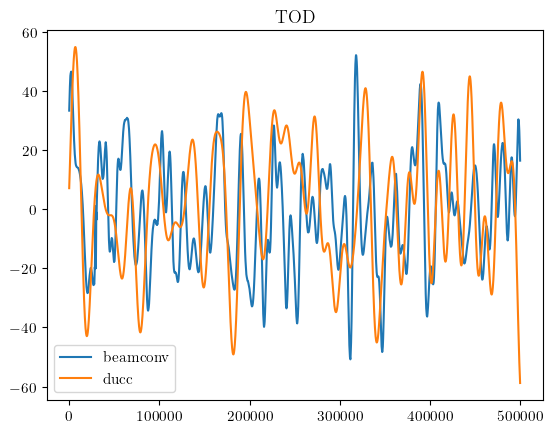

In [92]:
plt.plot(signal_beamconv[:500000],label='beamconv')
plt.plot(signal_muellerconvolver[:500000],label='ducc')
#plt.ylim([0.5475,0.5485])
plt.title(r'TOD')
plt.legend()
plt.show()

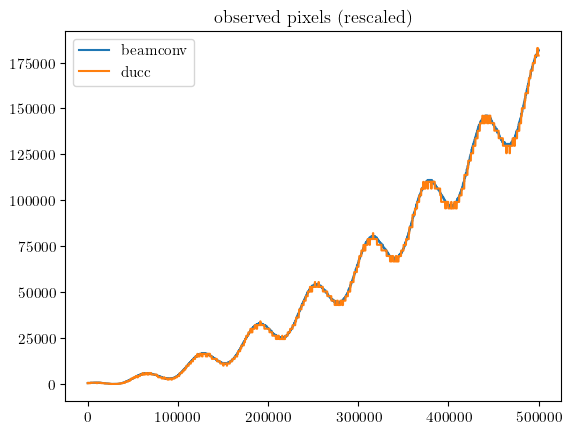

In [64]:
plt.plot(pixels_beamconv[:500000], label='beamconv')
plt.plot(pixs[:500000]*(256/nside)**2, label='ducc')
plt.title(r'observed pixels (rescaled)')
plt.legend()
plt.show()